In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import json

# Backend

GLOBAL SETTINGS: OMP_NUM_THREADS=12, OMP_PLACES=cores, OMP_PROC_BIND=spread,
REPEAT=3, SMALL_TASKS_NUM=120, BIG_TASK_NUM=12




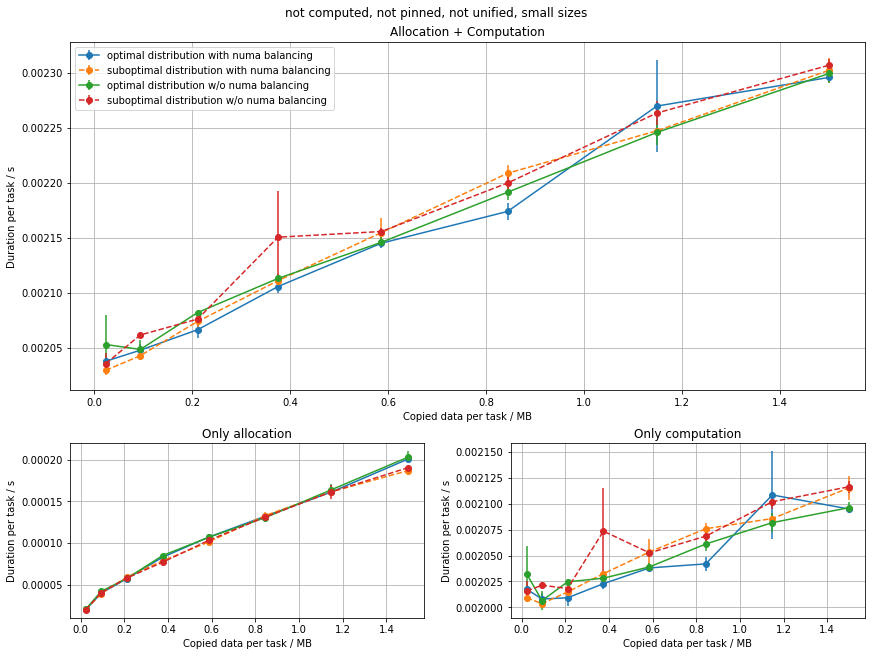

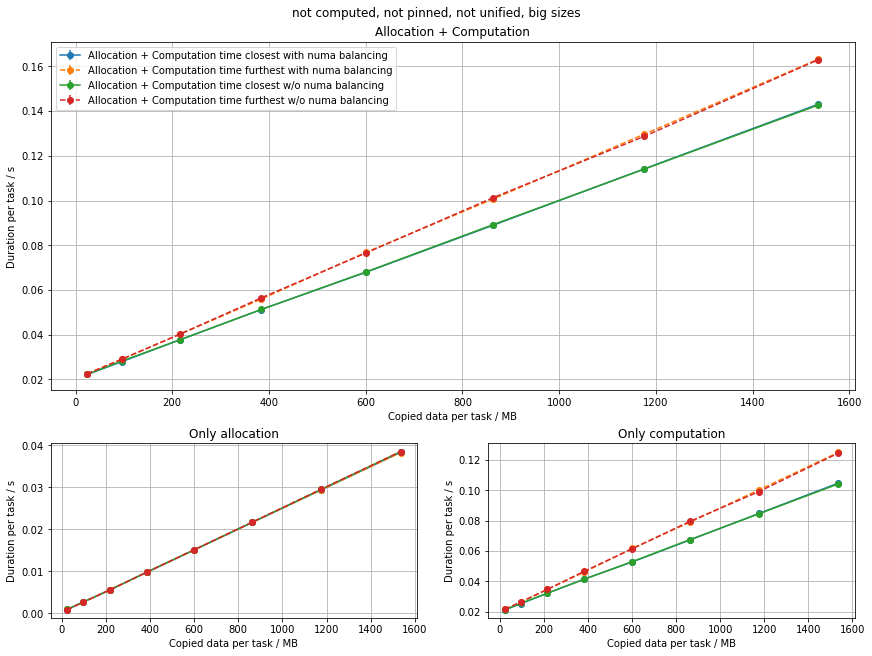

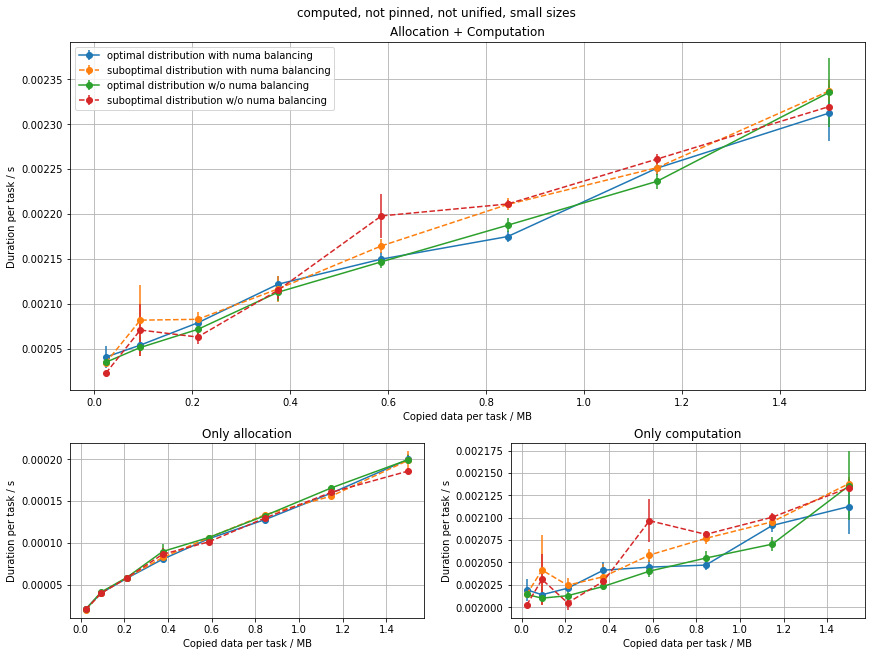

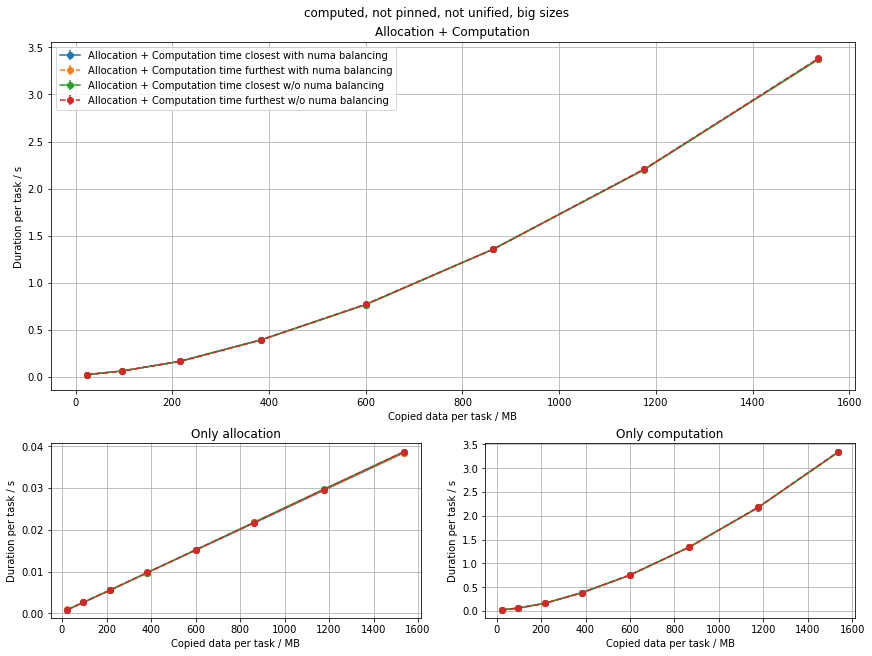

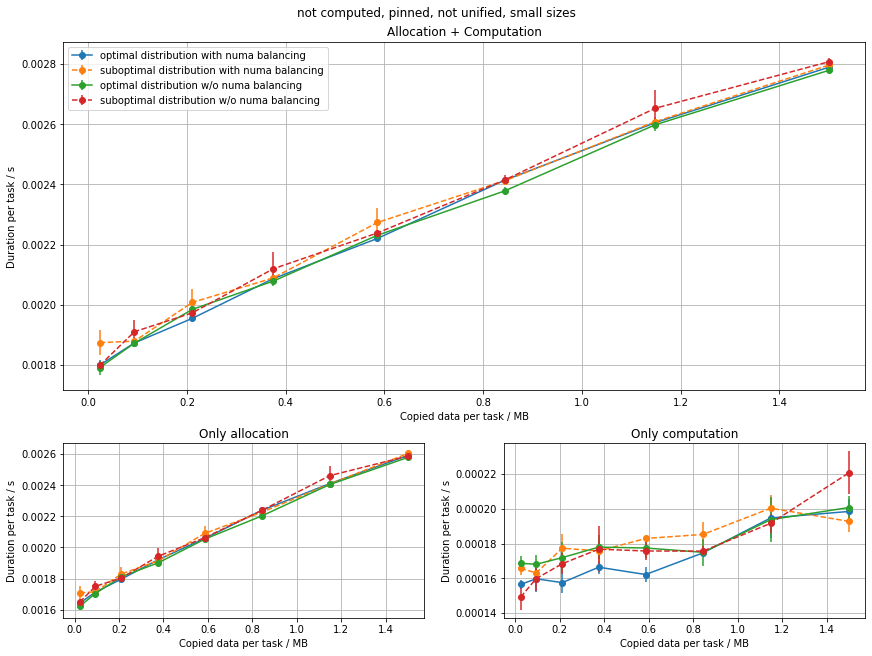

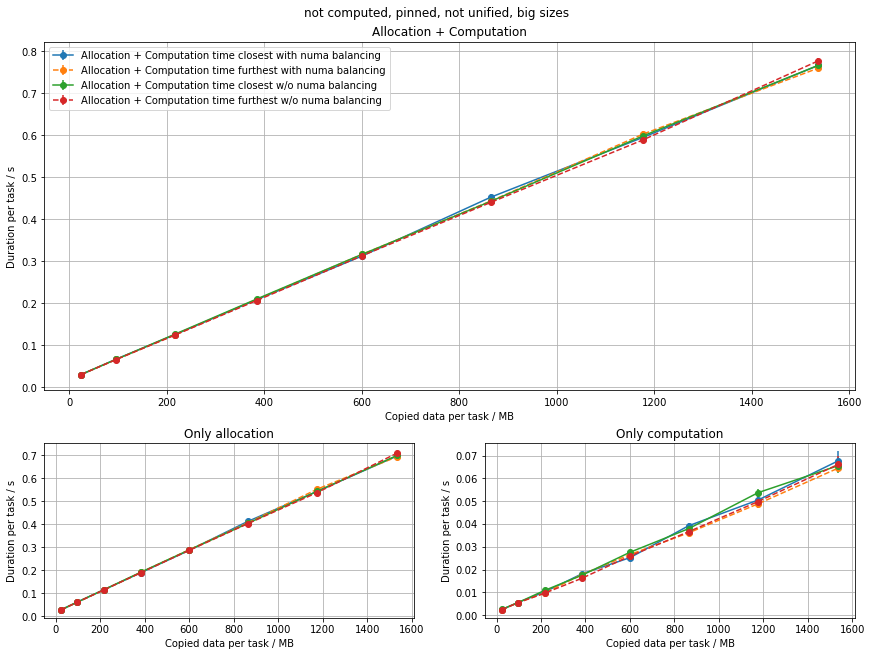

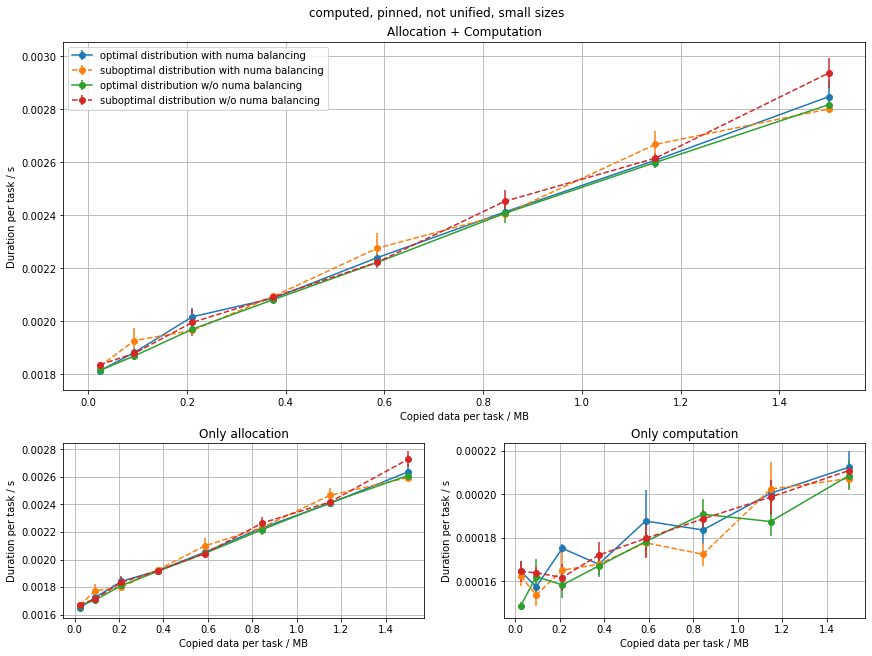

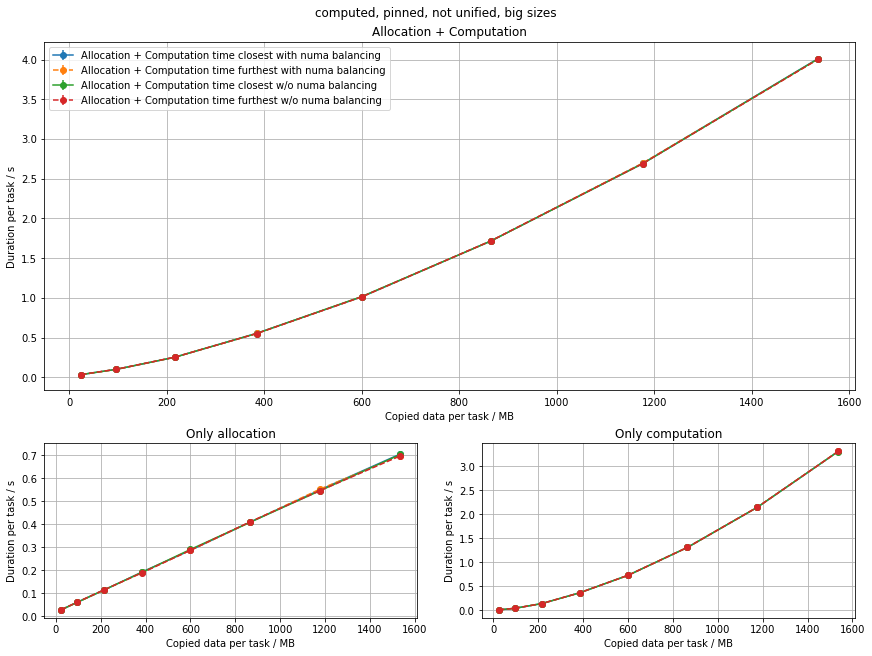

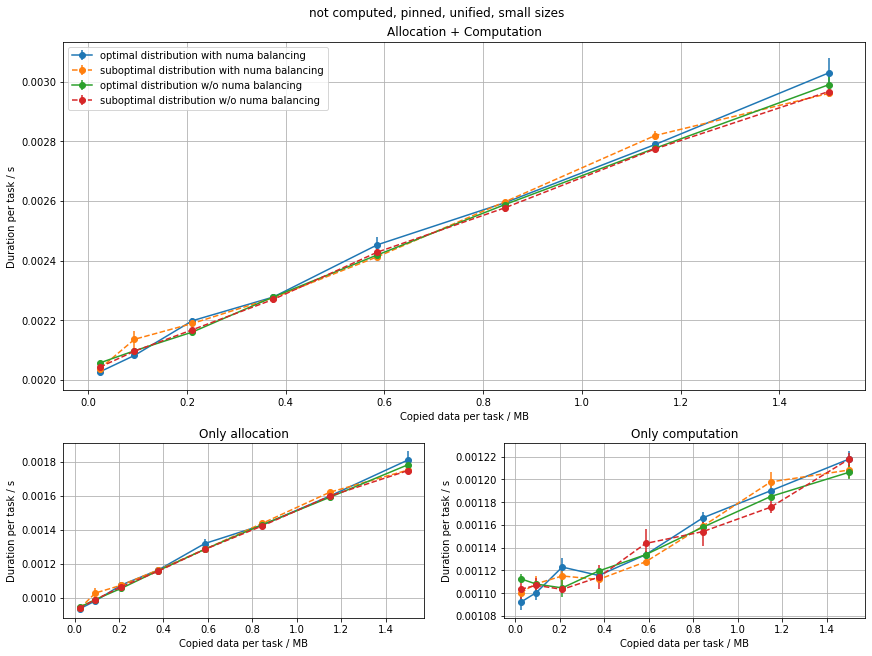

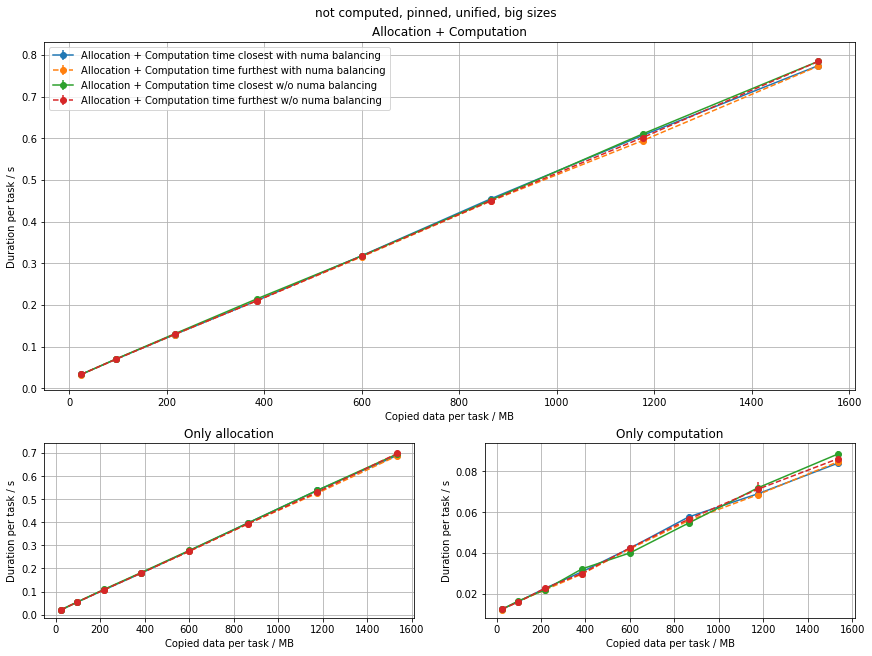

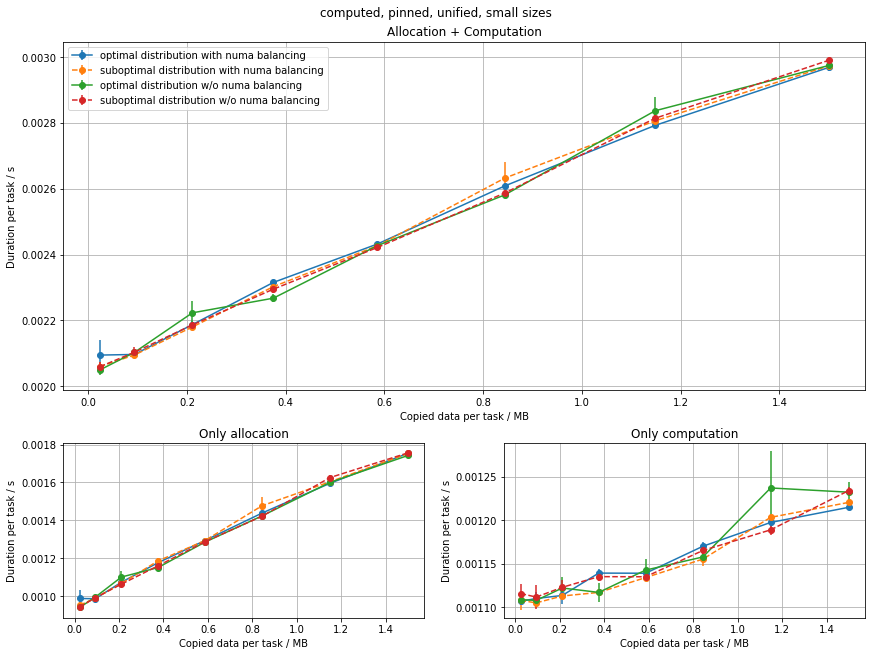

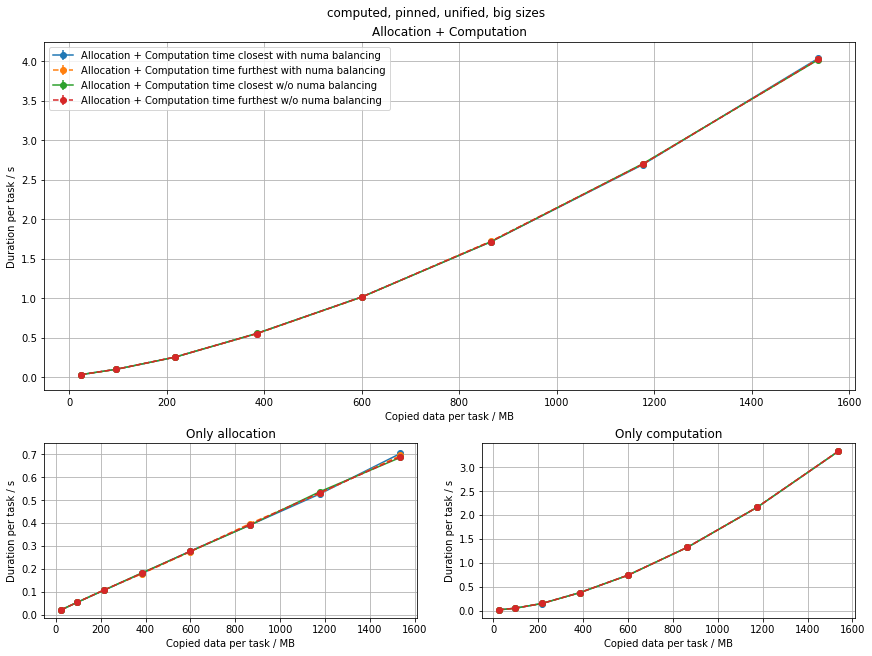

In [5]:
keys = ["bcpu", "bcp_", "bc__", "b_pu", "b_p_", "b___", "_cpu", "_cp_", "_c__", "__pu", "__p_", "____"]
data = {}
for k in keys:
    try:
        with open("./memory_benchmark/" + k + "/memory_benchmark_parsed.json", 'r') as f:
            data[k] = json.loads(f.read())
    except FileNotFoundError:
        print(k, "not found")
keys = [
    "spread_12_32 120", "spread_12_64 120", "spread_12_96 120", 
    "spread_12_128 120", "spread_12_160 120", "spread_12_192 120",
    "spread_12_224 120", "spread_12_256 120",
    "spread_12_1024 12", "spread_12_2048 12", "spread_12_3072 12",
    "spread_12_4096 12", "spread_12_5120 12", "spread_12_6144 12",
    "spread_12_7168 12", "spread_12_8192 12"
]

def create_title(config):
    c = "computed"
    p = "pinned"
    u = "unified"
    
    a = [c, p, u]
    for i in [0,1,2]:
        if config[i] == "_":
            a[i] = "not " + a[i]
    return ', '.join(a)

def plotup(c):
    #mb_per_thread = ([i*i*8/(1024**2)*10 for i in [32,64,96,128,160,192,224,256]])
    mb_per_thread = ([i*i*8/(1024**2)*3 for i in [1024,2048,3072,4096,5120,6144,7168,8192]])
    
    configs = []
    if "_" + c in data.keys():
        configs += ["_" + c]
    if "b" + c in data.keys():
        configs += ["b" + c]
        
    fig = plt.figure(constrained_layout=True, figsize=(12,9))
    gs = GridSpec(3, 2, figure=fig)
    ax_all = fig.add_subplot(gs[:2, :2])
    ax_allocate = fig.add_subplot(gs[2,0])
    ax_compute = fig.add_subplot(gs[2,1])
    
    for config in configs:
        balanced = "w/o numa balancing"
        if config[0] == "_":
            balanced = "with numa balancing"
            
        allocation_best = np.array([data[config][keys[i]]["best"]["allocation"]["average"] for i in range(8,8+len(mb_per_thread))])
        execution_best = np.array([data[config][keys[i]]["best"]["computation"]["average"] for i in range(8,8+len(mb_per_thread))])
        u_allocation_best = np.array([data[config][keys[i]]["best"]["allocation"]["derivation"] for i in range(8,8+len(mb_per_thread))])/np.sqrt(2)
        u_exection_best = np.array([data[config][keys[i]]["best"]["computation"]["derivation"] for i in range(8,8+len(mb_per_thread))])/np.sqrt(2)

        allocation_worst = np.array([data[config][keys[i]]["worst"]["allocation"]["average"] for i in range(8,8+len(mb_per_thread))])
        execution_worst = np.array([data[config][keys[i]]["worst"]["computation"]["average"] for i in range(8,8+len(mb_per_thread))])
        u_allocation_worst = np.array([data[config][keys[i]]["worst"]["allocation"]["derivation"] for i in range(8,8+len(mb_per_thread))])/np.sqrt(2)
        u_exection_worst = np.array([data[config][keys[i]]["worst"]["computation"]["derivation"] for i in range(8,8+len(mb_per_thread))])/np.sqrt(2)

        ax_allocate.errorbar(mb_per_thread, allocation_best/12, yerr=u_allocation_best/12, marker='o', label='optimal distribution ' + balanced)
        ax_allocate.errorbar(mb_per_thread, allocation_worst/12, yerr=u_allocation_worst/12, marker='o', linestyle='--', label='suboptimal distribution ' + balanced)
        ax_compute.errorbar(mb_per_thread, execution_best/12, yerr=u_exection_best/12, marker='o', label='optimal distribution ' + balanced)
        ax_compute.errorbar(mb_per_thread, execution_worst/12, yerr=u_exection_worst/12, marker='o', linestyle='--', label='suboptimal distribution ' + balanced)
        ax_all.errorbar(mb_per_thread, (allocation_best + execution_best)/12, yerr=np.sqrt(u_allocation_best**2+u_exection_best**2)/12, marker='o', label='Allocation + Computation time closest ' + balanced)
        ax_all.errorbar(mb_per_thread, (allocation_worst + execution_worst)/12, yerr=np.sqrt(u_allocation_worst**2+u_exection_worst**2)/12, marker='o', linestyle='--', label='Allocation + Computation time furthest ' + balanced)
    
        m,i= max(list(zip(((allocation_worst + execution_worst) - (allocation_best + execution_best))/(allocation_best + execution_best),range(len(execution_worst)))))
        mi, i2 = min(list(zip(((allocation_worst + execution_worst) - (allocation_best + execution_best))/(allocation_best + execution_best),range(len(execution_worst)))))
        #a = (allocation_best + execution_best)[i]
        #b = (allocation_worst + execution_worst)[i]
        #print(m,i)

        #print(balanced)
        #print('Min relative difference', mb_per_thread[i2], 'MB,', mi*100,"%")
        #print('Max relative difference', mb_per_thread[i], 'MB,', m*100,"%")
        #print()
    
    fig.suptitle(create_title(c) + ", big sizes")
    
    ax_all.set_title("Allocation + Computation")
    ax_all.set_xlabel("Copied data per task / MB")
    ax_all.set_ylabel("Duration per task / s")
    ax_all.grid()
    ax_all.legend()
    
    ax_allocate.set_title("Only allocation")
    ax_allocate.set_xlabel("Copied data per task / MB")
    ax_allocate.set_ylabel("Duration per task / s")
    ax_allocate.grid()
    
    ax_compute.set_title("Only computation")
    ax_compute.set_xlabel("Copied data per task / MB")
    ax_compute.set_ylabel("Duration per task / s")
    ax_compute.grid()
    
    
def plotdown(c):
    mb_per_thread = ([i*i*8/(1024**2)*3 for i in [32,64,96,128,160,192,224,256]])
    #mb_per_thread = ([i*i*8/(1024**2)*12 for i in [1024,2048,3072,4096,5120,6144,7168,8192]])
    configs = []
    if "_" + c in data.keys():
        configs += ["_" + c]
    if "b" + c in data.keys():
        configs += ["b" + c]
        
    #plt.rcParams["figure.figsize"] = (12,9)
    fig = plt.figure(constrained_layout=True, figsize=(12,9))
    gs = GridSpec(3, 2, figure=fig)
    ax_all = fig.add_subplot(gs[:2, :2])
    ax_allocate = fig.add_subplot(gs[2,0])
    ax_compute = fig.add_subplot(gs[2,1])
        
    for config in configs:
        balanced = "w/o numa balancing"
        if config[0] == "_":
            balanced = "with numa balancing"
            
        allocation_best = np.array([data[config][keys[i]]["best"]["allocation"]["average"] for i in range(len(mb_per_thread))])
        execution_best = np.array([data[config][keys[i]]["best"]["computation"]["average"] for i in range(len(mb_per_thread))])
        u_allocation_best = np.array([data[config][keys[i]]["best"]["allocation"]["derivation"] for i in range(len(mb_per_thread))])/np.sqrt(2)
        u_exection_best = np.array([data[config][keys[i]]["best"]["computation"]["derivation"] for i in range(len(mb_per_thread))])/np.sqrt(2)

        allocation_worst = np.array([data[config][keys[i]]["worst"]["allocation"]["average"] for i in range(len(mb_per_thread))])
        execution_worst = np.array([data[config][keys[i]]["worst"]["computation"]["average"] for i in range(len(mb_per_thread))])
        u_allocation_worst = np.array([data[config][keys[i]]["worst"]["allocation"]["derivation"] for i in range(len(mb_per_thread))])/np.sqrt(2)
        u_exection_worst = np.array([data[config][keys[i]]["worst"]["computation"]["derivation"] for i in range(len(mb_per_thread))])/np.sqrt(2)

        ax_allocate.errorbar(mb_per_thread, allocation_best/120, yerr=u_allocation_best/120, marker='o', label='optimal distribution ' + balanced)
        ax_allocate.errorbar(mb_per_thread, allocation_worst/120, yerr=u_allocation_worst/120, marker='o', linestyle='--', label='suboptimal distribution ' + balanced)
        ax_compute.errorbar(mb_per_thread, execution_best/120, yerr=u_exection_best/120, marker='o', label='optimal distribution ' + balanced)
        ax_compute.errorbar(mb_per_thread, execution_worst/120, yerr=u_exection_worst/120, marker='o', linestyle='--', label='suboptimal distribution ' + balanced)
        ax_all.errorbar(mb_per_thread, (allocation_best + execution_best)/120, yerr=np.sqrt(u_allocation_best**2+u_exection_best**2)/120, marker='o', label='optimal distribution ' + balanced)
        ax_all.errorbar(mb_per_thread, (allocation_worst + execution_worst)/120, yerr=np.sqrt(u_allocation_worst**2+u_exection_worst**2)/120, marker='o', linestyle='--', label='suboptimal distribution ' + balanced)
    
        m,i= max(list(zip(((allocation_worst + execution_worst) - (allocation_best + execution_best))/(allocation_best + execution_best),range(len(execution_worst)))))
        mi, i2 = min(list(zip(((allocation_worst + execution_worst) - (allocation_best + execution_best))/(allocation_best + execution_best),range(len(execution_worst)))))
        #a = (allocation_best + execution_best)[i]
        #b = (allocation_worst + execution_worst)[i]
        #print(m,i)

        #print(balanced)
        #print('Min relative difference', mb_per_thread[i2], 'MB,', mi*100,"%")
        #print('Max relative difference', mb_per_thread[i], 'MB,', m*100,"%")
        #print()
    
    fig.suptitle(create_title(c) + ", small sizes")
    
    ax_all.set_title("Allocation + Computation")
    ax_all.set_xlabel("Copied data per task / MB")
    ax_all.set_ylabel("Duration per task / s")
    ax_all.grid()
    ax_all.legend()
    
    ax_allocate.set_title("Only allocation")
    ax_allocate.set_xlabel("Copied data per task / MB")
    ax_allocate.set_ylabel("Duration per task / s")
    ax_allocate.grid()
    
    ax_compute.set_title("Only computation")
    ax_compute.set_xlabel("Copied data per task / MB")
    ax_compute.set_ylabel("Duration per task / s")
    ax_compute.grid()
    
print("GLOBAL SETTINGS: OMP_NUM_THREADS=12, OMP_PLACES=cores, OMP_PROC_BIND=spread,\nREPEAT=3, SMALL_TASKS_NUM=120, BIG_TASK_NUM=12")
print("\n")
configs = ["___", "c__", "_p_", "cp_", "_pu", "cpu"]
for k in configs:
    plotdown(k)
    plotup(k)

# Login

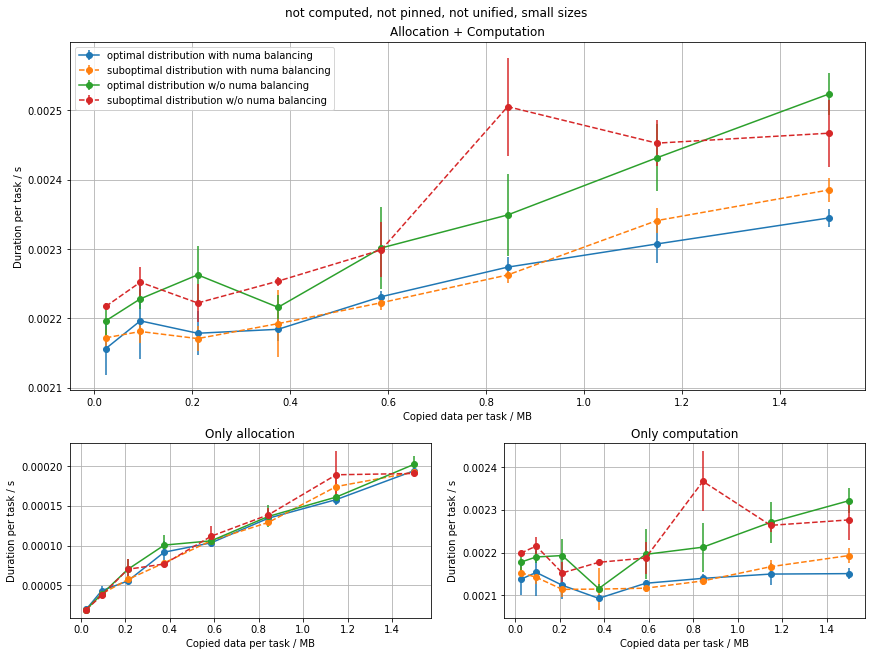

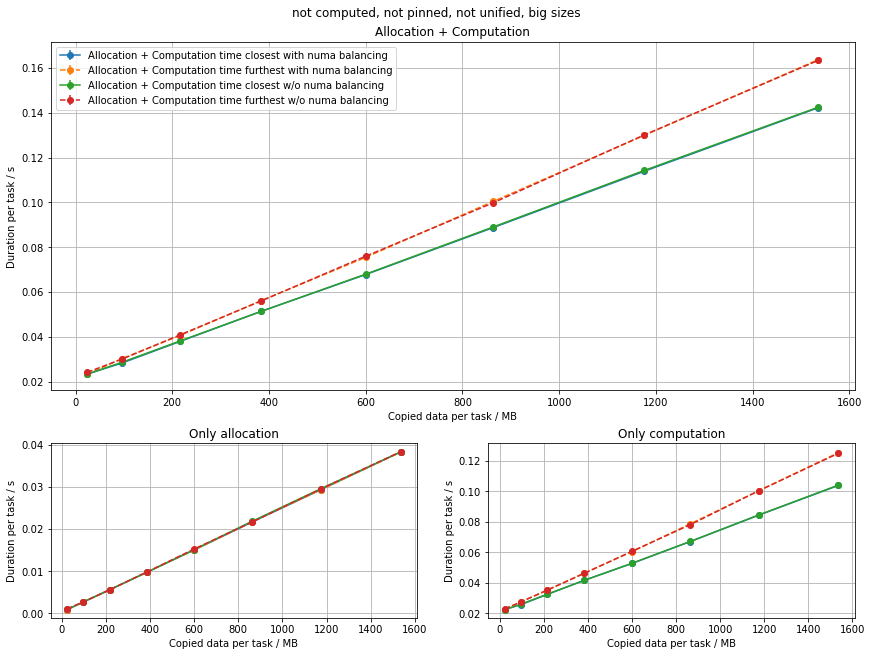

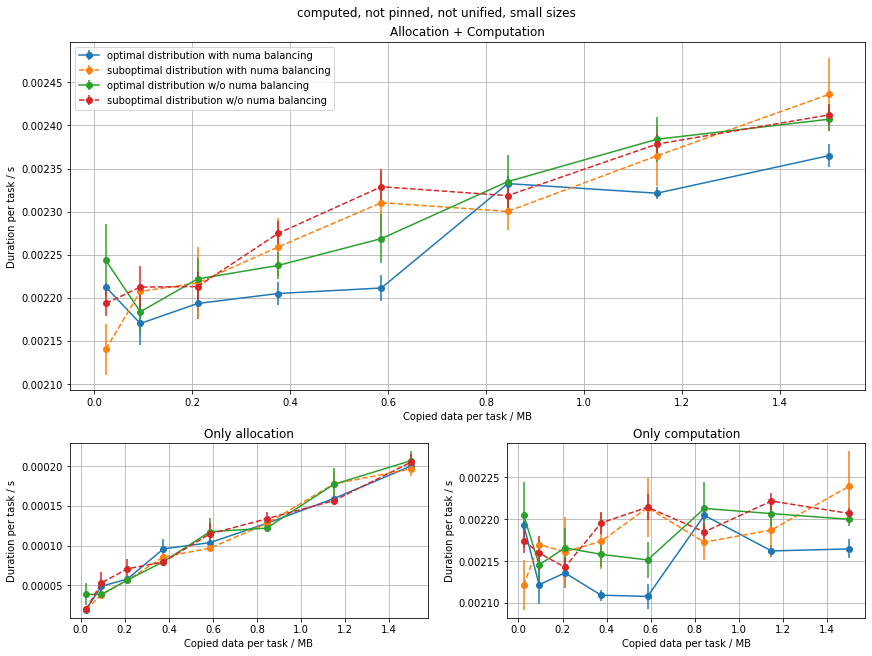

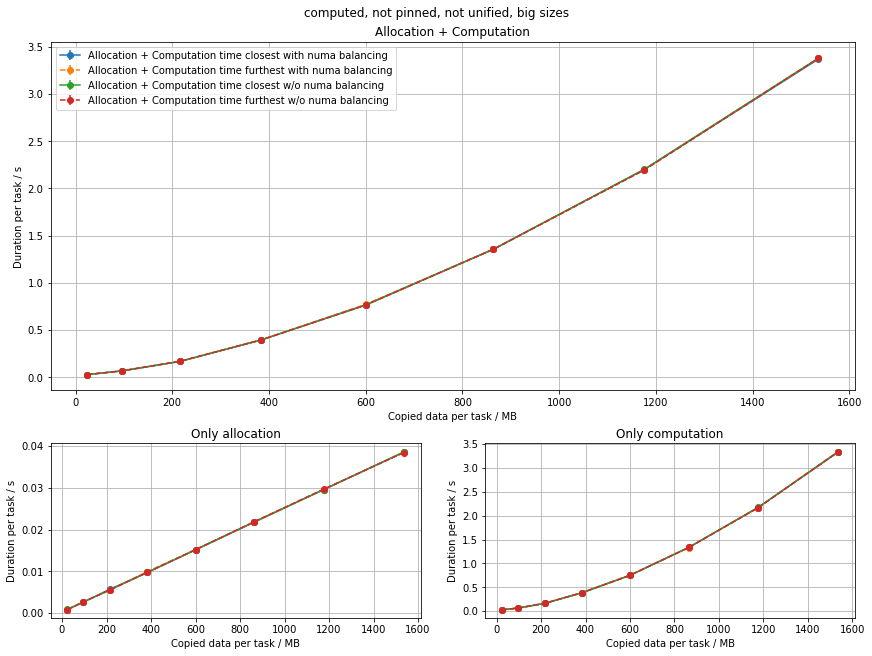

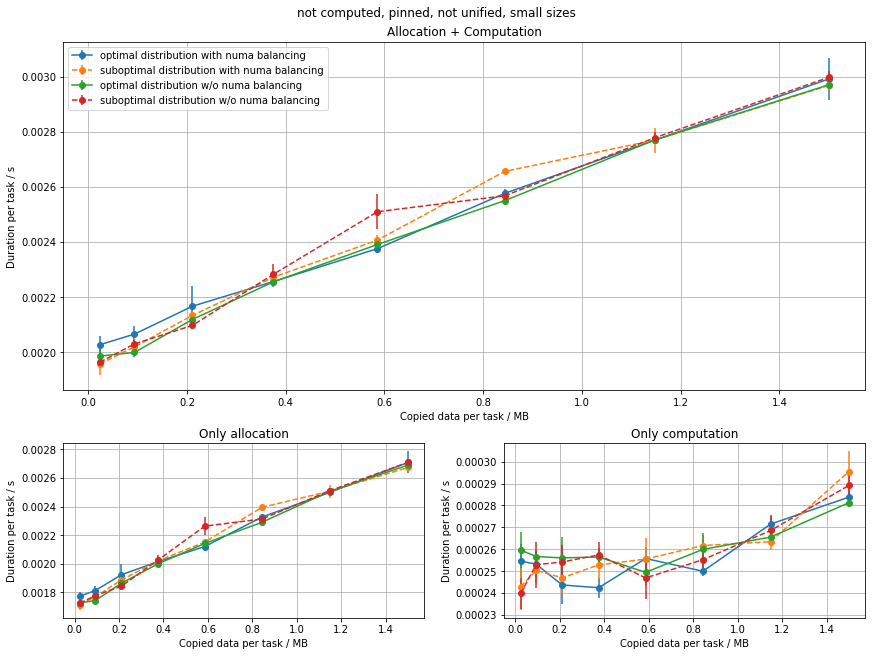

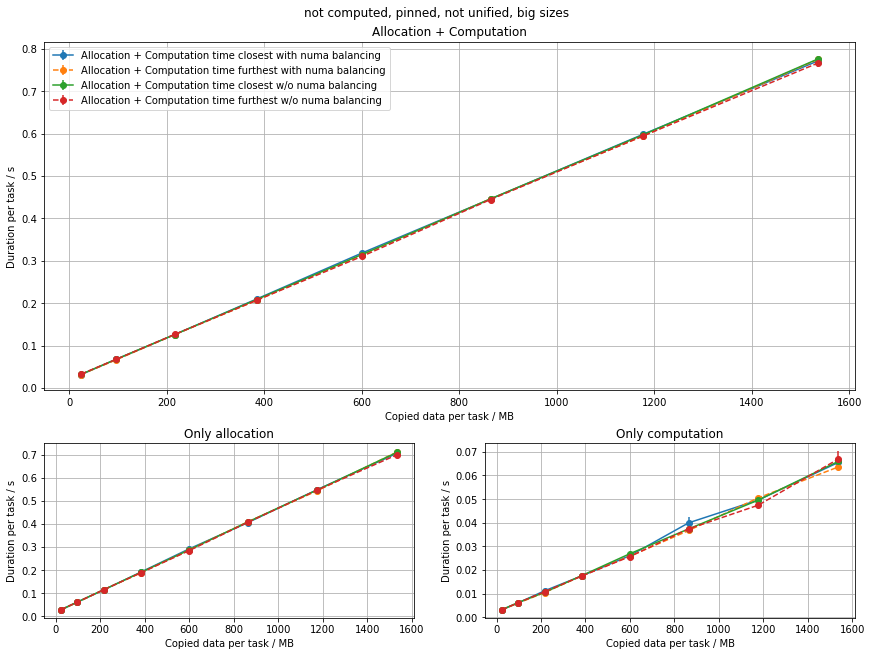

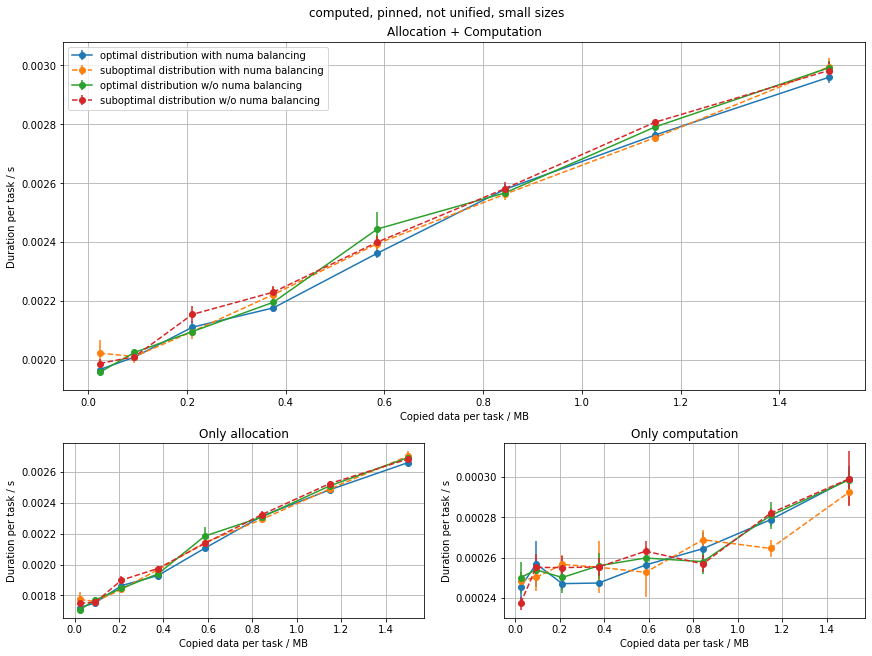

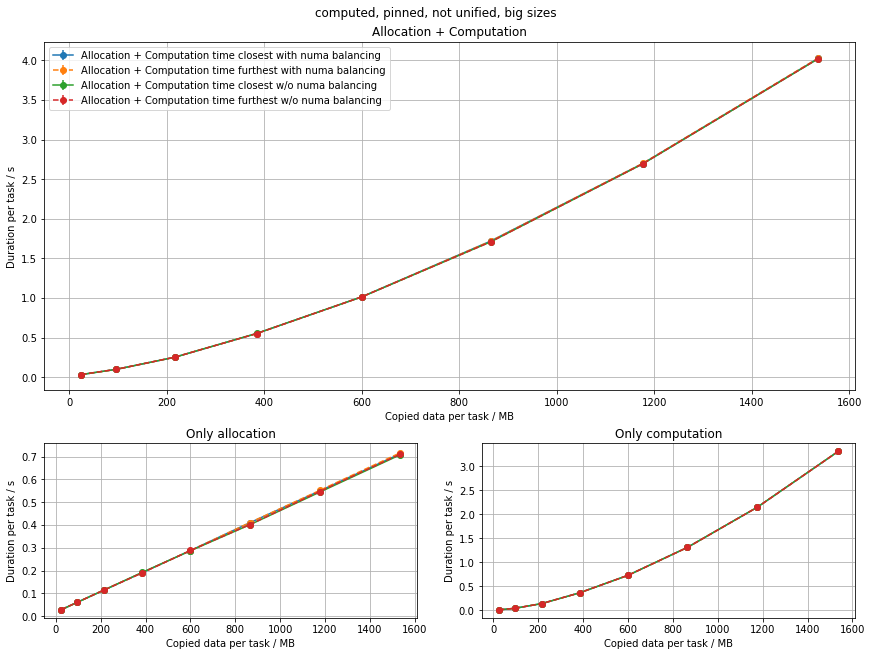

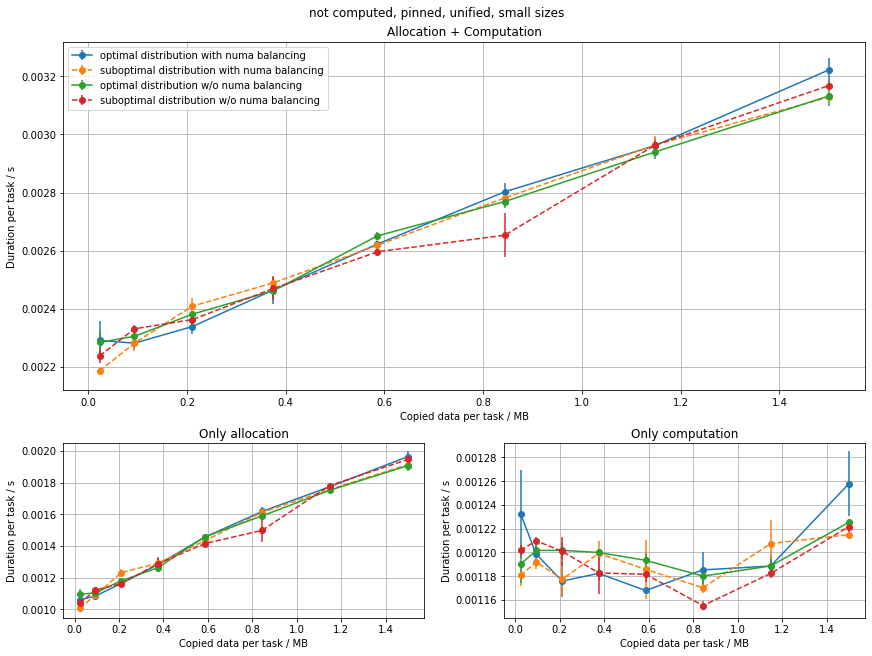

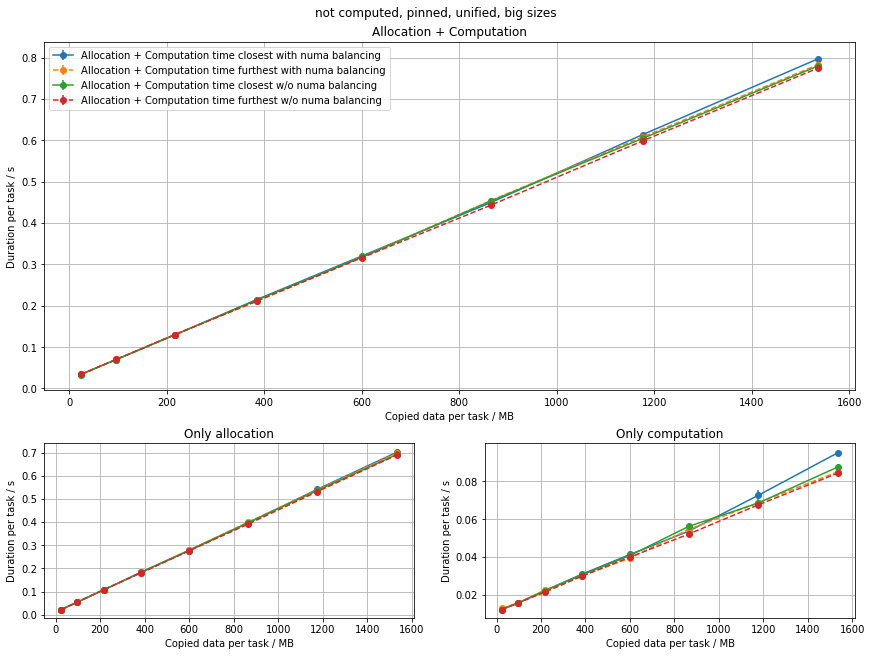

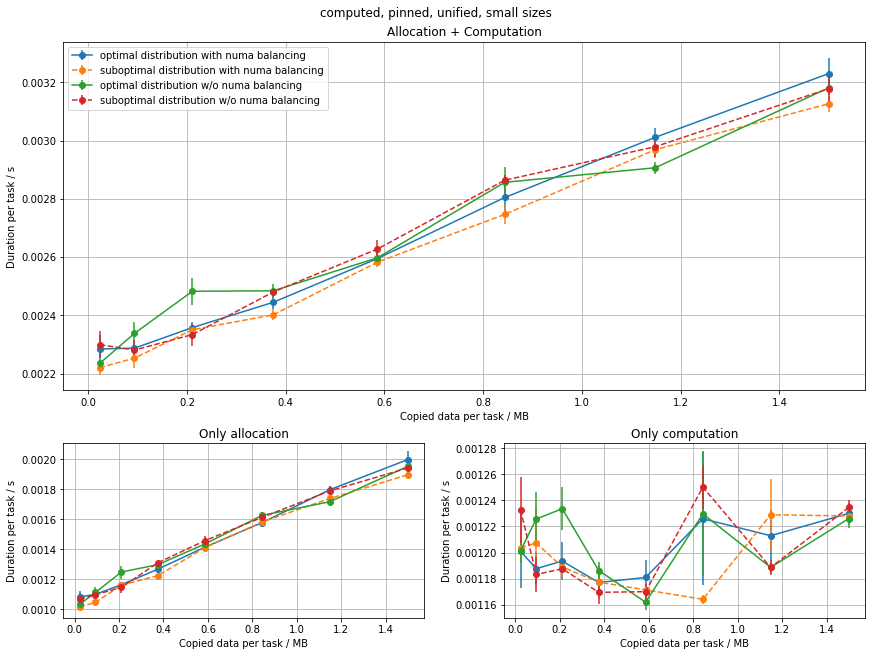

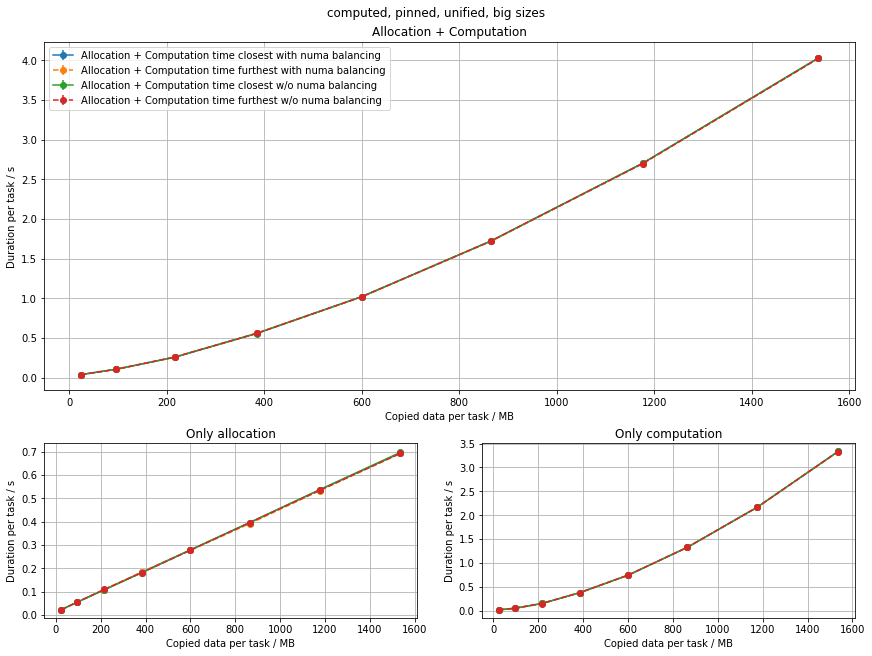

In [38]:
keys = ["bcpu", "bcp_", "bc__", "b_pu", "b_p_", "b___", "_cpu", "_cp_", "_c__", "__pu", "__p_", "____"]
data = {}
for k in keys:
    try:
        with open("./memory_benchmark_login/" + k + "/memory_benchmark_parsed.json", 'r') as f:
            data[k] = json.loads(f.read())
    except FileNotFoundError:
        print(k, "not found")
        
keys = [
    "spread_12_32 120", "spread_12_64 120", "spread_12_96 120", 
    "spread_12_128 120", "spread_12_160 120", "spread_12_192 120",
    "spread_12_224 120", "spread_12_256 120",
    "spread_12_1024 12", "spread_12_2048 12", "spread_12_3072 12",
    "spread_12_4096 12", "spread_12_5120 12", "spread_12_6144 12",
    "spread_12_7168 12", "spread_12_8192 12"
]
        
configs = ["___", "c__", "_p_", "cp_", "_pu", "cpu"]
for k in configs:
    plotdown(k)
    plotup(k)